In [1]:
import os 
import numpy as np
import pandas as pd 

from typing import Any, Dict, List

import seaborn as sns
import matplotlib.pyplot as plt

import scipy.stats as stats

# from etl import file_access

## Data Source: https://www.hockey-reference.com/leagues/NHL_2022.html ##
path = '/Users/rschraeder/Desktop/Projects/StanleyCupPredictions/data/'

# NHL 2022 Season Performance Predictions

In this analysis, I use current known stats in the NHL to predict outcomes for a team matchup. With statistical testing, exploratory analysis, and ensemble classification, my goal is to determine the outcome of a team matchup.

## Datasets

The data included is very robust, including all current information and some metrics for team performance. I import a league history of games during the regular season as well as each team's overall stats. You'll notice I incorporated feature engineering into the imports. This helps me keep things tight so I don't worry about conflicts after merging the data together. The cleaning was performed in a separate notebook to keep this clean and organized. 

#### Team Statistics

In [2]:
df = pd.read_csv(os.path.join(path, 'team_stats.csv'))
print(df.columns)
df.head()

Index(['Rk', 'Team', 'AvAge', 'GP', 'W', 'L', 'OL', 'PTS', 'PTS%', 'GF', 'GA',
       'SOW', 'SOL', 'SRS', 'SOS', 'GF/G', 'GA/G', 'PP', 'PPO', 'PP%', 'PPA',
       'PPOA', 'PK%', 'SH', 'SHA', 'PIM/G', 'oPIM/G', 'S', 'S%', 'SA', 'SV%',
       'SO', 'G', 'PPG', 'SHOOTOUTS'],
      dtype='object')


,Rk,Team,AvAge,GP,W,L,OL,PTS,PTS%,GF,...,PIM/G,oPIM/G,S,S%,SA,SV%,SO,G,PPG,SHOOTOUTS
0,1,Florida Panthers,27.8,82,58,18,6,122,0.744,337,...,10.1,10.8,3062,11.0,2515,0.904,5,579,117,7
1,2,Colorado Avalanche,28.2,82,56,19,7,119,0.726,308,...,9.0,10.4,2874,10.7,2625,0.912,7,540,115,6
2,3,Carolina Hurricanes,28.3,82,54,20,8,116,0.707,277,...,9.2,7.7,2798,9.9,2310,0.913,6,477,84,3
3,4,Toronto Maple Leafs,28.4,82,54,21,7,115,0.701,312,...,8.6,8.5,2835,11.0,2511,0.900,7,564,105,4
4,5,Minnesota Wild,29.4,82,53,22,7,113,0.689,305,...,10.8,10.8,2666,11.4,2577,0.903,3,554,116,9


#### Regular Season Games

In [3]:
games = pd.read_csv(os.path.join(path, 'regular_season.csv'))
print(games.columns)
games.head()

Index(['date', 'away_team', 'away_goals', 'home_team', 'home_goals',
       'length_of_game_min', 'outcome', 'home_wins'],
      dtype='object')


,date,away_team,away_goals,home_team,home_goals,length_of_game_min,outcome,home_wins
0,2021-10-12,Pittsburgh Penguins,6,Tampa Bay Lightning,2,153,1,0
1,2021-10-12,Seattle Kraken,3,Vegas Golden Knights,4,145,0,1
2,2021-10-13,Winnipeg Jets,1,Anaheim Ducks,4,149,0,1
3,2021-10-13,Chicago Blackhawks,2,Colorado Avalanche,4,152,0,1
4,2021-10-13,Vancouver Canucks,2,Edmonton Oilers,3,162,0,1


## Glossary 

### Team Statistics

| Metric | Description |
| :---        |    :----:   |
| Rk | Rank |
| AvAge | Average age of team weighted by time on ice. |
| GP | Games Played |
| W | Wins |
| L | Losses |
| OL | Overtime/Shootout Losses (2000 season onward) |
| PTS | Points |
| PTS% | Points percentage (i.e., points divided by maximum points) |
| GF | Goals For |
| GA | Goals Against |
| SOW | Shootout Wins |
| SOL | Shootout Losses |
| SRS | Simple Rating System; a team rating that takes into account average goal differential and strength of schedule. The rating is denominated in goals above/below average, where zero is average. |
| SOS | Strength of Schedule; a rating of strength of schedule. The rating is denominated in goals above/below average, where zero is average. |
| GF/G | Goals For Per Game |
| GA/G | Goals Against Per Game |
| PP | Power Play Goals | 
| PPO | Power Play Opportunities |
| PP% | Power Play Percentage |
| PPA | Power Play Goals Against |
| PPOA | Power Play Opportunities Against |
| PK% | Penalty Killing Percentage |
| SH | Short-Handed Goals |
| SHA | Short-Handed Goals Against |
| PIM/G | Penalties in Minutes Per Game |
| oPIM/G | Opponent Penalties in Minutes Per Game |
| S | Shots on Goal |
| S% | Shooting Percentage |
| SA | Shots Against |
| SV% | Save Percentage |
| SO | Shutouts (i.e. games where no goals are scored against the team in question. |

### Regular Season History
| Metric | Description |
| ------ | ----------- |
| date | Date of Game |
| away_team | Away Team |
| away_goals | Away Goals |
| home_team | Home Team |
| home_goals | Home Goals |
| length_of_game_min | Duration of Game |
| outcome | Away Win (used as predictor) |
| home_wins | Home Win |

## Exploratory Data Analysis

### Correlations

Plotting correlations in the data, I'm looking at any relationships at least 70% positively correlated and less than a 100% correlation (absolute) to focus on variables of interest. 

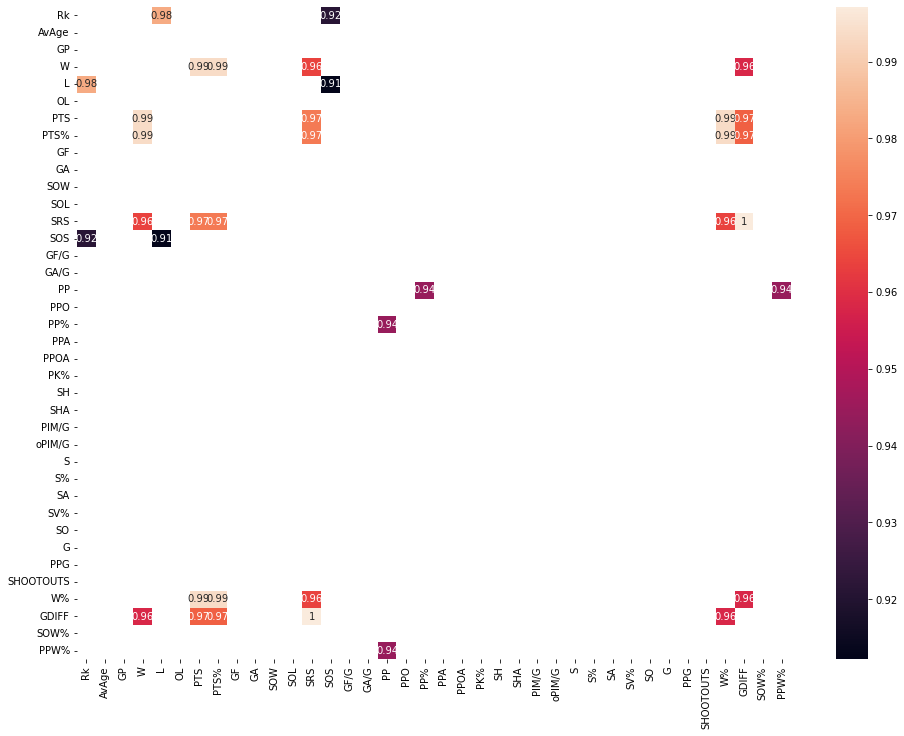

Top 10 Correlations


,variable,value
5,SRS,0.997141
10,GDIFF,0.997141
1,W,0.993766
3,PTS,0.993766
9,W%,0.993766
4,PTS%,0.993735
0,Rk,0.983110
2,L,0.983110
7,PP,0.944191
11,PPW%,0.944191


In [15]:
## Correlation Matrix
import seaborn as sns
import matplotlib.pyplot as plt 

plt.figure(figsize=(16,12))

corr = df.corr() # all correlations
corr = corr[np.logical_and(corr>0.90, corr<.9999)].abs()

# Determining strongest correlation patterns
strong_corrs_df = pd.DataFrame({k:v for k, v in corr[~corr.isna()].max().dropna().items()}, index=[0]).melt()
strong_corrs_df = strong_corrs_df.sort_values('value', ascending=False).head(10)

sns.heatmap(corr, annot=True)

plt.show()

## Top 10 Correlations
print('Top 10 Correlations')
strong_corrs_df

### Summary 

Looking at the strongest of correlations, we can tell that Wins, Losses, Points, Point Percentage, the Simple Rating System (SRS), Strength of Schedule, Power Play, and Power Play Percentage are the most correlated variables. Here are the strongest correlations:

- **Wins to Points & Point Percentage**
- **Points & Point Percentage to SRS** 
- **Wins to SRS**
- **Losses to Strength of Schedule (SOS)**
- **Power Play to Power Play Percentage**

The SRS is an all-around stat measuring a team's goal differential to the strength of their game schedule. If they had performed at home to a weaker team, they would have a high schedule strength. Paired with the positive goal differential, this means the team is fairly dominant. 

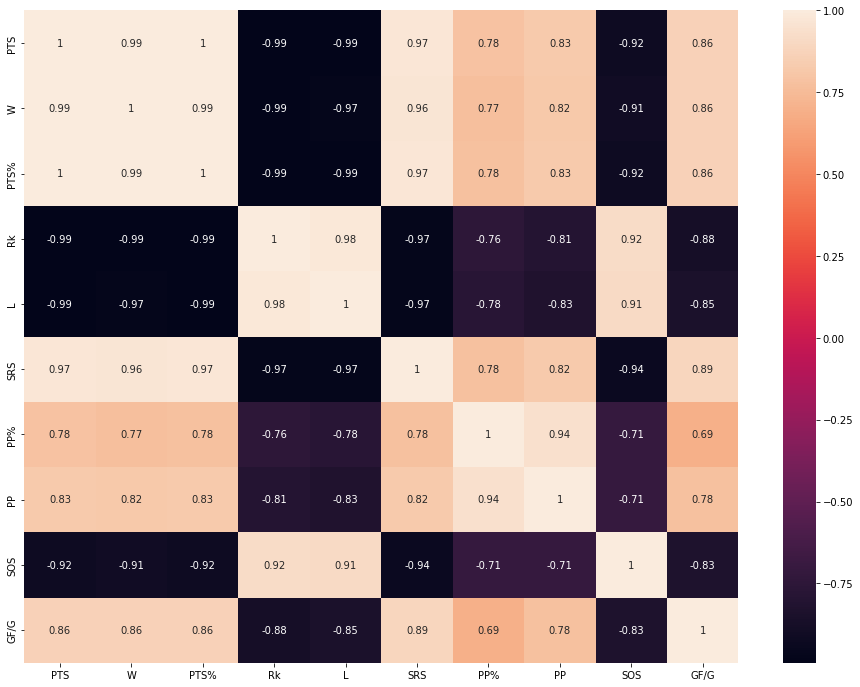

In [5]:
## Plotting strongest correlations 
plt.figure(figsize=(16,12))

top_10_corr = df[strong_corrs_df.variable.to_list()].corr()
sns.heatmap(top_10_corr, annot=True)
plt.savefig('../../images/top_10_correlations.png')

plt.show()


Having a better look at these correlations, it makes a good amount of sense as we'd be biased in understanding. 
Some key points to take: 
1. GF/G -> PP, SOS Correlation: The greater goals scored may not determine strength on the powerplay entirely, as a powerplay performer would likely be more strategic and many different factors influence a powerplay. The strength of schedule can also be weaker, in other words the ease of a team to score goals must mean they have less difficult games. It should be more difficult to score on a better team (obviously). 
2. Losses and Rank: The more losses, the lower the rank
3. Wins and Rank: The more wins, the higher the rank

## Feature Engineering
**_Determining features based upon EDA and working towards diving further into them_**

It appears that I'll need to focus on win, point, power play, and schedule statistics. To encapsulate some further insight, I'll need to create some features that summarize goals and can draw statistics from them we can measure based upon wins. These can be tied in as performance metrics, and if conducive, will reveal more insight into the top teams in the league. 

In [6]:
## Creating percentages for new metrics and columns
def ratio_maker(df: pd.DataFrame, newcol: str, xcol: str, ycol: str) -> Any: 
    df[f"{newcol}"] = (df[f"{xcol}"] / df[f"{ycol}"])*100

## Calc new metrics and store in new cols 
ratio_maker(df, "W%", "W", "GP") # win-loss percentage. wins / games played
ratio_maker(df, "GDIFF", "GF", "G") # goal differential. goals for / (goals for + goals against)
ratio_maker(df, "SOW%", "SOW", "SHOOTOUTS") # shootout win-loss ratio. shootout wins / shootout games. 
ratio_maker(df, "PPW%", "PP", "PPO") # power-play success percentage. power play goals / power play opportunities

df.head()

,Rk,Team,AvAge,GP,W,L,OL,PTS,PTS%,GF,...,SA,SV%,SO,G,PPG,SHOOTOUTS,W%,GDIFF,SOW%,PPW%
0,1,Florida Panthers,27.8,82,58,18,6,122,0.744,337,...,2515,0.904,5,579,117,7,70.731707,58.203800,42.857143,24.427481
1,2,Colorado Avalanche,28.2,82,56,19,7,119,0.726,308,...,2625,0.912,7,540,115,6,68.292683,57.037037,66.666667,24.014337
2,3,Carolina Hurricanes,28.3,82,54,20,8,116,0.707,277,...,2310,0.913,6,477,84,3,65.853659,58.071279,33.333333,21.982759
3,4,Toronto Maple Leafs,28.4,82,54,21,7,115,0.701,312,...,2511,0.900,7,564,105,4,65.853659,55.319149,75.000000,27.272727
4,5,Minnesota Wild,29.4,82,53,22,7,113,0.689,305,...,2577,0.903,3,554,116,9,64.634146,55.054152,55.555556,20.542636


_Here, I created:_
- a win percentage (W%)
- goal differential (GDIFF)
- win percentage in games leading to shootout (SOW%)
- performance on the power play (PPW%)
#### As an example, here are the top ten teams as shown with these metrics. 

In [12]:
winners = df[['Rk','Team','W%', 'GDIFF', 'SOW%', 'PPW%', 'PK%']].sort_values('Rk', ascending=True).head(10)
winners

,Rk,Team,W%,GDIFF,SOW%,PPW%,PK%
0,1,Florida Panthers,70.731707,58.203800,42.857143,24.427481,79.54
1,2,Colorado Avalanche,68.292683,57.037037,66.666667,24.014337,79.66
2,3,Carolina Hurricanes,65.853659,58.071279,33.333333,21.982759,88.04
3,4,Toronto Maple Leafs,65.853659,55.319149,75.000000,27.272727,82.05
4,5,Minnesota Wild,64.634146,55.054152,55.555556,20.542636,76.14
5,6,Calgary Flames,60.975610,58.551308,50.000000,22.881356,83.20
6,7,Tampa Bay Lightning,62.195122,55.555556,28.571429,23.938224,80.56
7,8,New York Rangers,63.414634,55.066079,57.142857,25.229358,82.30
8,9,St. Louis Blues,59.756098,56.386861,40.000000,26.970954,84.09
9,10,Boston Bruins,62.195122,53.715499,50.000000,21.186441,81.30


Some key takeways: 
- Shootouts (SOW%) are low for teams currently in the playoffs and performing well: Tampa Bay Lightning (28.5%), Carolina Hurricanes (33.33%), Florida Panthers (42.8%). 
- The upper bound of all metrics shows a high win-loss percentage, meaning a positive record

#### Averaging the Metrics 
By taking the averages of goal differential, shootout win percentage, and power-play win percentage, I want to see if the overall win percentage is affected

In [8]:
avg = []
for i, j in winners.iloc[:,2:].iterrows(): 
    avg.append(j.mean())
    
winners['avg_overall'] = avg
winners = winners.sort_values('avg_overall', ascending=False)
winners

,Rk,Team,W%,GDIFF,SOW%,PPW%,avg_overall
3,4,Toronto Maple Leafs,65.853659,55.319149,75.000000,27.272727,55.861384
1,2,Colorado Avalanche,68.292683,57.037037,66.666667,24.014337,54.002681
7,8,New York Rangers,63.414634,55.066079,57.142857,25.229358,50.213232
0,1,Florida Panthers,70.731707,58.203800,42.857143,24.427481,49.055033
4,5,Minnesota Wild,64.634146,55.054152,55.555556,20.542636,48.946622
5,6,Calgary Flames,60.975610,58.551308,50.000000,22.881356,48.102068
9,10,Boston Bruins,62.195122,53.715499,50.000000,21.186441,46.774265
8,9,St. Louis Blues,59.756098,56.386861,40.000000,26.970954,45.778478
2,3,Carolina Hurricanes,65.853659,58.071279,33.333333,21.982759,44.810257
6,7,Tampa Bay Lightning,62.195122,55.555556,28.571429,23.938224,42.565083


An interesting note here is the high shootout performance of the Toronto Maple Leafs. Their overall win percentage is close to their average performance overall due to this. When looking at the Florida Panthers who are ranked first, however, they have the second highest goal differential but the highest win percentage. The statistic bringing their overall success down is their lesser performance than others in shootouts. It seems here that's an influential factor toward playoff readiness, which is understandable. 

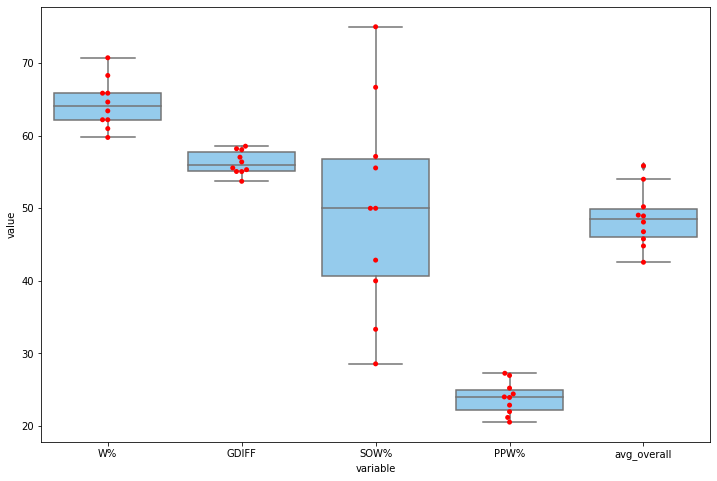

In [9]:
plt.figure(figsize=(12,8))

winners_melt = pd.melt(winners, id_vars=['Rk', 'Team'], value_vars=['W%', 'GDIFF', 'SOW%', 'PPW%', 'avg_overall'])
winners_melt.sort_values('Rk')

ax = sns.boxplot(x='variable', y='value', data=winners_melt, color='lightskyblue')
ax = sns.swarmplot(x='variable', y='value', data=winners_melt, color='red')


The team performance is indicated by rank, and the rank appears to be directly related to the higher level of these statistics: 

- Goal differential is not as varied, showing it is hard to get a high differential. 
- The widest range here is shootout win percentages - teams with the best seem to be rated the best.

> Statistical Tests 
>- i) To ensure this is accurate, I can conduct a One-Way ANoVA (multiple factor test to determine the variance of variables results in a group mean of zero, if true, and therefore significant in influencing an output). 
>- ii) I also noticed that rank as an output variable would be a reliable predictor. To test this, I can add a Spearman's Rho correlation test as rank data is scaled. This will show what correlates with rank significantly. 

### Hypothesis Testing 

Given enough analysis, I'll form some hypotheses to test formally: 

- _H0_: Win percentage, goal differential, shootout wins, and power-play wins all have equal means, and thus have a direct impact on overall team record
- _H1_: All such variables do not have equal means, and thus no impact on overall team record 

Ranked Hypotheses: 

- _H0_: Features seen positively correlated with game wins have a strong positive correlation with the team's league rank. 
- _H1_: All such variables do not have an impact on the team's league rank. 

In [10]:
## One-Way ANOVA

fvalue, pvalue = stats.f_oneway(df['W%'], df['GDIFF'], df['SOW%'])
fvalue, pvalue

(0.021630613505153103, 0.9786065723652804)

In [11]:
## Spearman's RHO Ranked Test. Can also used Mann-Whitney U-Test for categorical rank outcomes. In this case, it's numerical.

spearman = df[['Rk', 'W', 'L', 'GDIFF', 'SOW%', 'PTS', 'PTS%', 'SRS', 'SOS', 'PP', 'PP%']].corr(method='spearman')
spearman[:1].abs().melt() # absolute value, as rank is inverse and will show as a negative correlation. 


,variable,value
0,Rk,1.000000
1,W,0.985872
2,L,0.991744
3,GDIFF,0.962977
4,SOW%,0.043815
5,PTS,0.999908
6,PTS%,0.999908
7,SRS,0.970119
8,SOS,0.924839
9,PP,0.820692


#### Summary 

1) One-Way ANOVA

The test concludes with a high f-statistic, which is expected. The percentages are widely varied and there are 32 teams. The p-value suggests that among the variance, group means are equal for the metrics selected and thus influence win rate. The alternate hypothesis is proven, so these tested variables have a significant impact on overall wins. 

2) Spearman's RHO Rank Test

The test concludes with a high correlation spread. I took the absolute value, since as the rank goes up, there is a negative implication. The lower the rank, the better the team. As seen in the summary of correlations, the points and goal differential determine a team's rank, but that is determined heavily upon the strength of their schedule and their powerplay performance. If a team is reliable on the power-play, they tend to perform better. This makes sense given a team will need to draw penalties from their opponent to gain an additional player or even 5-on-3 advantage, which increases odds for players to get goals. 